In [1]:
import re
import json
import numpy as np
import pandas as pd
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords

import pymorphy2

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
df1 = pd.read_csv('Reviews_0.csv', sep = '|')#первоначальный датасет
df1.head()

,Unnamed: 0,rating,header,review
0,0,Оценка:5Проверяется,Благодарность,"<div class=""responses__item__message markup-in..."
1,1,Оценка:1Проверяется,"Не могу воспользоваться призом, полученным по ...","<div class=""responses__item__message markup-in..."
2,2,Оценка:1Проверяется,"Банк меня обманывает клиентов, никому не реком...","<div class=""responses__item__message markup-in..."
3,3,Оценка:5Проверяется,Очень лояльное отношение к клиентам,"<div class=""responses__item__message markup-in..."
4,4,Оценка:1Проверяется,"АО ""Россельхозбанк"" не исполняет решение суда","<div class=""responses__item__message markup-in..."


In [3]:
reviews_data = df1[:1000]#пока возьмем тысячу 

In [4]:
def clean_review(review): #функция для очистки отзывов
    
    review = re.split(r'[^а-яА-яёЁ]+', str(review).lower())#оставляем только русские слова, приведем к нижнему регистру
    morph = pymorphy2.MorphAnalyzer()#лемматизация для русского языка
    review = [morph.parse(word)[0].normal_form for word in review if word not in set(stopwords.words("russian"))]#убираем стоп слова
    review = " ".join(review)
    return review

In [5]:
reviews_data['review'] = reviews_data['review'].apply(clean_review) #очистили

In [6]:
reviews_data.to_csv('rshb')#сохраним и разметим в экселе

In [7]:
reviews_data.head()

,Unnamed: 0,rating,header,review
0,0,Оценка:5Проверяется,Благодарность,хотеть поблагодарить сотрудник россельхозбанк...
1,1,Оценка:1Проверяется,"Не могу воспользоваться призом, полученным по ...",принимать участие акция оплатить покупка карт...
2,2,Оценка:1Проверяется,"Банк меня обманывает клиентов, никому не реком...",повестись реклама дебетовый карта хозяин данн...
3,3,Оценка:5Проверяется,Очень лояльное отношение к клиентам,решить супруга взять ипотека узнать самый выг...
4,4,Оценка:1Проверяется,"АО ""Россельхозбанк"" не исполняет решение суда",июнь год я мой супруга передать к взыскание и...


In [8]:
df = pd.read_csv('rshb.csv')#размеченный датасет
df.head()

,Unnamed: 0,Unnamed: 0.1,rating,header,review
0,0,5,Оценка:5Проверяется,Благодарность,хотеть поблагодарить сотрудник россельхозбанк...
1,1,1,Оценка:1Проверяется,"Не могу воспользоваться призом, полученным по ...",принимать участие акция оплатить покупка карт...
2,2,1,Оценка:1Проверяется,"Банк меня обманывает клиентов, никому не реком...",повестись реклама дебетовый карта хозяин данн...
3,3,5,Оценка:5Проверяется,Очень лояльное отношение к клиентам,решить супруга взять ипотека узнать самый выг...
4,4,1,Оценка:1Проверяется,"АО ""Россельхозбанк"" не исполняет решение суда",июнь год я мой супруга передать к взыскание и...


#### Во время разметки несложно было заметить, что оценки 1-3 - жалоба, 4-5 - благодарности, и если люди ставят оценку, то они не ошибаются, основная проблема была с отзывами без оценки, в большинстве таких отзывов люди просто не ставили оценку по непонятным причинам. Интересны случаи, когда клиенты жаловались, но писали "пока без оценки" :)

In [9]:
d_new= {'1': 0, '2':0, '3':0, '4':1,'5':1, 'н':2}
df['Unnamed: 0.1'] = df['Unnamed: 0.1'].map(d_new)

In [10]:
df.rename(columns={'Unnamed: 0.1':'class'}, inplace=True)

In [11]:
df['class'].value_counts() #наверное, недостаточно вопросов

0    706
1    273
2     21
Name: class, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['class'], test_size=0.3,random_state = 0)
#векторизация
cv = CountVectorizer()
cv.fit(X_train)
tf = TfidfVectorizer()
tf.fit(X_train)
X_train_counts = cv.transform(X_train)
X_train_tf = tf.transform(X_train)

In [13]:
X_train_tf.shape

(700, 5904)

## Сразу попробуем построить логрег и лес, count, tf

In [14]:
logit = LogisticRegression(multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit.fit(X_train_counts, y_train)

X_test_counts = cv.transform(X_test)
y_logit_pred = logit.predict(X_test_counts)
print(metrics.classification_report(y_test, y_logit_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       212
           1       0.96      0.94      0.95        81
           2       0.00      0.00      0.00         7

   micro avg       0.94      0.94      0.94       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.93      0.94      0.94       300



In [15]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train_counts, y_train)

X_test_counts = cv.transform(X_test)
y_rfc_pred = rfc.predict(X_test_counts)
print(metrics.classification_report(y_test, y_rfc_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       212
           1       0.91      0.79      0.85        81
           2       0.00      0.00      0.00         7

   micro avg       0.90      0.90      0.90       300
   macro avg       0.60      0.59      0.59       300
weighted avg       0.88      0.90      0.89       300



In [16]:
logit1 = LogisticRegression(C=100,multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit1.fit(X_train_tf, y_train)

X_test_tf1 = tf.transform(X_test)
y_logit_tf_pred1 = logit1.predict(X_test_tf1)
print(metrics.classification_report(y_test, y_logit_tf_pred1))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       212
           1       1.00      0.96      0.98        81
           2       0.00      0.00      0.00         7

   micro avg       0.97      0.97      0.97       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.94      0.97      0.96       300



In [17]:
logit = LogisticRegression(multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit.fit(X_train_tf, y_train)

X_test_tf = tf.transform(X_test)
y_logit_tf_pred = logit.predict(X_test_tf)
print(metrics.classification_report(y_test, y_logit_tf_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       212
           1       1.00      0.89      0.94        81
           2       0.00      0.00      0.00         7

   micro avg       0.95      0.95      0.95       300
   macro avg       0.64      0.63      0.63       300
weighted avg       0.93      0.95      0.94       300



In [18]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train_tf, y_train)

X_test_counts = tf.transform(X_test)
y_rfc_tf_pred = rfc.predict(X_test_tf)
print(metrics.classification_report(y_test, y_rfc_tf_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       212
           1       0.94      0.81      0.87        81
           2       0.00      0.00      0.00         7

   micro avg       0.91      0.91      0.91       300
   macro avg       0.62      0.60      0.61       300
weighted avg       0.89      0.91      0.90       300



### Возможно, не хватает данных, добавим оставшиеся 1500 тысячи отзывов

In [19]:
df1[1001:2500][df1[1001:2500]['rating'] == 'Без оценки'].to_csv('questions.csv')

In [20]:
def clean_review2(review): #попробуем без лемматизации
    
    review = re.split(r'[^а-яА-яёЁ]+', str(review).lower())
    review = " ".join(review)
    return review

In [21]:
df2 = pd.read_csv('Reviews_0.csv', sep = '|')
df2.head()

,Unnamed: 0,rating,header,review
0,0,Оценка:5Проверяется,Благодарность,"<div class=""responses__item__message markup-in..."
1,1,Оценка:1Проверяется,"Не могу воспользоваться призом, полученным по ...","<div class=""responses__item__message markup-in..."
2,2,Оценка:1Проверяется,"Банк меня обманывает клиентов, никому не реком...","<div class=""responses__item__message markup-in..."
3,3,Оценка:5Проверяется,Очень лояльное отношение к клиентам,"<div class=""responses__item__message markup-in..."
4,4,Оценка:1Проверяется,"АО ""Россельхозбанк"" не исполняет решение суда","<div class=""responses__item__message markup-in..."


In [22]:
df2['review'] = df2['review'].apply(clean_review2)

In [23]:
def get_mark(mark): #функция чтобы вытащить оценку из 'rating'
    return mark[7] 

In [24]:
df2['rating'].value_counts()

Оценка:1Проверяется        491
Оценка:1                   404
Оценка:5Не засчитана       317
Оценка:1Не засчитана       313
Без оценки                 246
Оценка:1Проблема решена    218
Оценка:5Проверяется        182
Оценка:2                    76
Оценка:2Проблема решена     56
Оценка:5                    51
Оценка:2Не засчитана        40
Оценка:2Проверяется         24
Оценка:3                    22
Оценка:4                    18
Оценка:3Проблема решена     13
Оценка:3Не засчитана        11
Оценка:3Проверяется          9
Оценка:4Не засчитана         7
Оценка:4Проверяется          2
Name: rating, dtype: int64

In [25]:
df2['rating'] = df2['rating'].apply(get_mark)
df2.head()

,Unnamed: 0,rating,header,review
0,0,5,Благодарность,хочу поблагодарить сотрудников россельхозбанк...
1,1,1,"Не могу воспользоваться призом, полученным по ...",принимал участие в акции оплатите покупки кар...
2,2,1,"Банк меня обманывает клиентов, никому не реком...",повелся на рекламу дебетовой карты хозяина от...
3,3,5,Очень лояльное отношение к клиентам,решили с супругой взять ипотеку узнали что са...
4,4,1,"АО ""Россельхозбанк"" не исполняет решение суда",июня г мною и моей супругой были переданы ко ...


In [26]:
df2[df2['rating'] == 'н'].shape

(246, 4)

In [27]:
df2[df2['rating'] == 'н'].to_csv('check_questions.csv') #снова сохраним для разметки в экселе

In [28]:
df3 = pd.read_csv('checked_questions - check_questions.csv') #датасет только с вопросами
df3[df3['rating'] == 'н'].shape

(64, 3)

In [29]:
df_new = df2[df2['rating'] != 'н']

In [30]:
df2.head()

,Unnamed: 0,rating,header,review
0,0,5,Благодарность,хочу поблагодарить сотрудников россельхозбанк...
1,1,1,"Не могу воспользоваться призом, полученным по ...",принимал участие в акции оплатите покупки кар...
2,2,1,"Банк меня обманывает клиентов, никому не реком...",повелся на рекламу дебетовой карты хозяина от...
3,3,5,Очень лояльное отношение к клиентам,решили с супругой взять ипотеку узнали что са...
4,4,1,"АО ""Россельхозбанк"" не исполняет решение суда",июня г мною и моей супругой были переданы ко ...


In [31]:
df_new = df_new.drop(['Unnamed: 0'],axis = 1)

In [32]:
df3 = df3.dropna()

## Попытки с 2500 отзывами

In [33]:
df_new.head()

,rating,header,review
0,5,Благодарность,хочу поблагодарить сотрудников россельхозбанк...
1,1,"Не могу воспользоваться призом, полученным по ...",принимал участие в акции оплатите покупки кар...
2,1,"Банк меня обманывает клиентов, никому не реком...",повелся на рекламу дебетовой карты хозяина от...
3,5,Очень лояльное отношение к клиентам,решили с супругой взять ипотеку узнали что са...
4,1,"АО ""Россельхозбанк"" не исполняет решение суда",июня г мною и моей супругой были переданы ко ...


In [34]:
df_ = pd.concat([df_new,df3])

In [35]:
df_['review'] = df_['review'].apply(clean_review)

In [36]:
d_new= {'1': 0, '2':0, '3':0, '4':1,'5':1, 'н':2}  
df_['rating'] = df_['rating'].map(d_new)

In [37]:
df_.head()

,rating,header,review
0,1,Благодарность,хотеть поблагодарить сотрудник россельхозбанк...
1,0,"Не могу воспользоваться призом, полученным по ...",принимать участие акция оплатить покупка карт...
2,0,"Банк меня обманывает клиентов, никому не реком...",повестись реклама дебетовый карта хозяин данн...
3,1,Очень лояльное отношение к клиентам,решить супруга взять ипотека узнать самый выг...
4,0,"АО ""Россельхозбанк"" не исполняет решение суда",июнь год я мой супруга передать к взыскание и...


####  сильный дисбаланс классов, количество вопросов мало

In [38]:
df_.rating.value_counts()

0    1854
1     581
2      64
Name: rating, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_['review'], df_['rating'], test_size=0.3,random_state = 0)
#векторизация
cv = CountVectorizer()
cv.fit(X_train)
tf = TfidfVectorizer()
tf.fit(X_train)
X_train_counts = cv.transform(X_train)
X_train_tf = tf.transform(X_train)

In [40]:
logit = LogisticRegression(C=100,multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit.fit(X_train_tf, y_train)

X_test_tf = tf.transform(X_test)
y_logit_tf_pred = logit.predict(X_test_tf)
print(metrics.classification_report(y_test, y_logit_tf_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       561
           1       0.98      0.93      0.96       169
           2       0.00      0.00      0.00        20

   micro avg       0.95      0.95      0.95       750
   macro avg       0.64      0.64      0.64       750
weighted avg       0.93      0.95      0.94       750



In [41]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train_tf, y_train)

X_test_counts = tf.transform(X_test)
y_rfc_tf_pred = rfc.predict(X_test_tf)
print(metrics.classification_report(y_test, y_rfc_tf_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95       561
           1       0.95      0.76      0.84       169
           2       0.00      0.00      0.00        20

   micro avg       0.91      0.91      0.91       750
   macro avg       0.62      0.58      0.60       750
weighted avg       0.89      0.91      0.90       750



### Посмотрим на распределение слов в нашем словаре, скорее всего много лишнего

In [42]:
vocab = list(cv.get_feature_names())

In [43]:
counts = X_train_counts.sum(axis=0).A1

In [44]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
freq_distribution = Counter(dict(zip(vocab, counts)))
print (freq_distribution.most_common()) #посмотрим на слова в словаре

[('банка', 3186), ('банк', 2412), ('карта', 2213), ('год', 1706), ('день', 1381), ('сотрудник', 1318), ('это', 1316), ('отделение', 1175), ('клиент', 1111), ('который', 1085), ('офис', 1042), ('россельхозбанк', 1036), ('мой', 977), ('ипотека', 925), ('документ', 898), ('счёт', 894), ('вопрос', 873), ('сказать', 832), ('свой', 806), ('условие', 775), ('кредит', 771), ('заявка', 760), ('деньга', 730), ('дать', 721), ('сумма', 707), ('такой', 676), ('время', 674), ('договор', 652), ('получить', 643), ('вклад', 640), ('обратиться', 634), ('рубль', 630), ('заявление', 620), ('ответ', 613), ('платёж', 611), ('мочь', 606), ('месяц', 589), ('очень', 561), ('кредитный', 542), ('один', 530), ('май', 519), ('весь', 517), ('операция', 480), ('информация', 476), ('том', 475), ('обслуживание', 471), ('хотеть', 463), ('работа', 458), ('программа', 449), ('срок', 448), ('решить', 446), ('проблема', 438), ('работать', 437), ('рсхб', 430), ('средство', 423), ('ситуация', 410), ('ставка', 408), ('просить

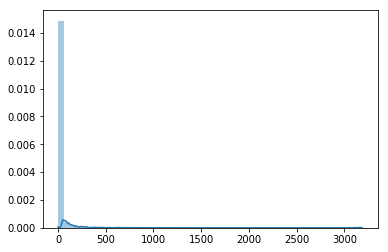

In [45]:
sns.distplot(counts)

#### Очень много слов, которые редко встречаются. Это могут быть опечатки или просто редко используемые слова, они никак не помогут модели найти нужные зависимости, так как встречаются в малом количестве отзывов, поэтому уберем токены, встречающиеся в менее 5 отзывах.

In [46]:
cv_without_rare = CountVectorizer(min_df=5)
cv_without_rare.fit(X_train)
X_train_counts2 = cv_without_rare.transform(X_train)

logit2 = LogisticRegression(C=0.1,multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit2.fit(X_train_counts2, y_train)

X_test_counts2 = cv_without_rare.transform(X_test)
y_logit_pred2 = logit2.predict(X_test_counts2)
print(metrics.classification_report(y_test, y_logit_pred2))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       561
           1       0.98      0.91      0.94       169
           2       0.50      0.05      0.09        20

   micro avg       0.95      0.95      0.95       750
   macro avg       0.81      0.65      0.67       750
weighted avg       0.94      0.95      0.94       750



#### первый раз видим не нули у вопросов

In [47]:
X_train_counts2.shape #стало

(1749, 2960)

In [48]:
X_train_counts.shape #было

(1749, 9608)

In [49]:
cv_without_rare_freq = TfidfVectorizer(min_df=15)
cv_without_rare_freq.fit(X_train)
X_train_counts3 = cv_without_rare_freq.transform(X_train)

logit3 = LogisticRegression(C=10000000,multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit3.fit(X_train_counts3, y_train)#поставил огромное C в надежде увидеть хоть что-то)

X_test_counts3 = cv_without_rare_freq.transform(X_test)
y_logit_pred3 = logit3.predict(X_test_counts3)
print(metrics.classification_report(y_test, y_logit_pred3))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       561
           1       0.92      0.95      0.94       169
           2       0.38      0.15      0.21        20

   micro avg       0.94      0.94      0.94       750
   macro avg       0.75      0.69      0.70       750
weighted avg       0.93      0.94      0.94       750



In [50]:
X_train_counts3.shape

(1749, 1460)

#### решил попрбовать  например 
## Без лемматизации

In [51]:
df_without_lemm = pd.concat([df_new,df3])

In [52]:
df_without_lemm['review'] = df_without_lemm['review'].apply(clean_review2)

In [53]:
df_without_lemm['rating'] = df_without_lemm['rating'].map(d_new)

In [54]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(df_without_lemm['review'], df_without_lemm['rating'], test_size=0.3,random_state = 0)
#векторизация
cv4 = CountVectorizer(min_df=5, max_df=0.75)
cv4.fit(X_train4)
X_train_counts4 = cv4.transform(X_train4)

In [55]:
logit4 = LogisticRegression(C=1,multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit4.fit(X_train_counts4, y_train4)

X_test_counts4 = cv4.transform(X_test4)
y_logit_pred4 = logit4.predict(X_test_counts4)
print(metrics.classification_report(y_test4, y_logit_pred4))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       561
           1       0.96      0.89      0.93       169
           2       0.33      0.05      0.09        20

   micro avg       0.94      0.94      0.94       750
   macro avg       0.75      0.64      0.66       750
weighted avg       0.93      0.94      0.93       750



In [56]:
tf4 = TfidfVectorizer(min_df=5)
tf4.fit(X_train4)
X_train_counts44 = tf4.transform(X_train4)

logit4 = LogisticRegression(C=10,multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit4.fit(X_train_counts44, y_train4)

X_test_counts44 = tf4.transform(X_test4)
y_logit_pred44 = logit4.predict(X_test_counts44)
print(metrics.classification_report(y_test4, y_logit_pred44))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       561
           1       0.99      0.89      0.94       169
           2       0.00      0.00      0.00        20

   micro avg       0.95      0.95      0.95       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.92      0.95      0.93       750



In [57]:
#cv_without_rare = CountVectorizer(min_df=10)
cv_without_rare = CountVectorizer(ngram_range=(1,2), min_df=5) 
cv_without_rare.fit(X_train)
X_train_counts2 = cv_without_rare.transform(X_train)

logit2 = LogisticRegression(C=1,multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit2.fit(X_train_counts2, y_train)

X_test_counts2 = cv_without_rare.transform(X_test)
y_logit_pred2 = logit2.predict(X_test_counts2)
print(metrics.classification_report(y_test, y_logit_pred2))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       561
           1       0.97      0.91      0.94       169
           2       0.20      0.05      0.08        20

   micro avg       0.95      0.95      0.95       750
   macro avg       0.71      0.65      0.66       750
weighted avg       0.93      0.95      0.94       750



#### Как и ожидалось, безуспешно, посмотрим тогда, например, на распределение вопросительных знаков в вопросах и жалобах, предполагая, что этих символов в вопросах будет больше

In [58]:
def count_vopros(review):
    return str(review).count('?')

In [59]:
#ниже сложные махинации с датасетами, тк нет размеченного датасета с неочищенными данными,
#здесь нужно заново скомпилировать загрузку df1, тк не изменяется в ноубуке :)
#в общем я использовал заголовки как ключ и сджоинил датасеты, чтобы взять неочищенные отзывы у вопросов,
#но там некоторые хедеры совпадают, так что немного грубая оценка (67 вместо 64)
df_try_1000 = pd.read_csv('questions.csv')
df_try_1000.head()

,Unnamed: 0,Unnamed: 0.1,rating,header,review
0,1001,1001,Без оценки,Отделение,"<div class=""responses__item__message markup-in..."
1,1017,1017,Без оценки,Сельская ипотека,"<div class=""responses__item__message markup-in..."
2,1023,1023,Без оценки,Банк отказывает в кредитных каникулах!!!,"<div class=""responses__item__message markup-in..."
3,1041,1041,Без оценки,Банк удерживает средства,"<div class=""responses__item__message markup-in..."
4,1048,1048,Без оценки,Банк затягивает решение по ипотеке,"<div class=""responses__item__message markup-in..."


In [60]:
df_try_1000['count?'] = df_try_1000['review'].apply(count_vopros)

In [61]:
df_try_1000['count?'].value_counts()

0    115
1     38
2     23
3      8
4      4
7      2
6      1
Name: count?, dtype: int64

In [62]:
df1['count?'] = df1['review'].apply(count_vopros)

In [63]:
df_test = df1[df1['rating'] == 'н'].loc[(df1['header'].isin(df3[df3['rating'] == 'н']['header']))]

In [64]:
df_test['count?'] = df_test['review'].apply(count_vopros)

In [65]:
df_test['count?'].value_counts() #распределение у вопросов

Series([], Name: count?, dtype: int64)

In [66]:
df_test['count?'].count()

0

In [67]:
df1[df1['rating'] == 'н'].loc[(df1['header'].isin(df3[df3['rating'] == 'н']['header']))]

,Unnamed: 0,rating,header,review,count?


In [68]:
df1['rating'] = df1['rating'].apply(get_mark)###

In [69]:
df_test2 = df1[df1['rating'] == '1']

In [70]:
df_test2['count?'] = df_test2['review'].apply(count_vopros)

In [71]:
df_test2['count?'].value_counts()#распределение у жалоб

0     1090
1      148
2       80
3       51
4       22
5       19
6        5
10       3
9        3
7        3
8        2
Name: count?, dtype: int64

#### Посмотрев на распределения, заметим, что и у жалоб и у вопросов в более половины случаев вообще нет вопросительного знака, предположение неудачное 

## Попробуем увеличить количество вопросов с помощью оверсэмплинга 

In [105]:
df_['rating'].value_counts()

0    1854
1     581
2      64
Name: rating, dtype: int64

In [137]:
num_samp = len(df_[df_['rating']==0])
oversampled_df = pd.concat([df_[df_['rating']==0],df_[df_['rating']==1].sample(num_samp, replace=True), df_[df_['rating']==2].sample(num_samp, replace=True)])

In [128]:
oversampled_df.shape

(5562, 3)

In [139]:
oversampled_df['rating'] = oversampled_df['rating'].map({2: 'вопрос',0:'жалоба',1:'благодарность'})

In [140]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(oversampled_df['review'], oversampled_df['rating'], test_size=0.3,random_state = 0)
cv_os = CountVectorizer(min_df=5) 
cv_os.fit(X_train_os)
X_train_counts_os = cv_os.transform(X_train_os)

logit_os = LogisticRegression(multi_class='multinomial',solver='lbfgs', n_jobs=-1, random_state=7)
logit_os.fit(X_train_counts_os, y_train_os)

X_test_counts_os = cv_os.transform(X_test_os)
y_logit_pred_os = logit_os.predict(X_test_counts_os)
print(metrics.classification_report(y_test_os, y_logit_pred_os))

               precision    recall  f1-score   support

благодарность       0.99      0.99      0.99       562
       вопрос       0.98      1.00      0.99       554
       жалоба       0.99      0.97      0.98       553

    micro avg       0.99      0.99      0.99      1669
    macro avg       0.99      0.99      0.99      1669
 weighted avg       0.99      0.99      0.99      1669



### Сразу получили отличный результат

### Попробовав много разных преобразований, базовых методов извлечения информации из текста(CountVectorizer, TfIdfVectorizer, отрезания редких/частых слов, n-граммы) ничего не получалось из-за несбалансированности классов. Как только я взял больше данных все заработало, я даже не стал строить более сложные модели, тк и обычная лог регрессия себя отлично показала ввиду большого количества признаков.